In [47]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import warnings
warnings.filterwarnings("ignore")
import pickle
import sys
main_path = r'../..'
sys.path.append(main_path)
from BayDS import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
folders = [r'F:\my\Prog\kaggle\Baydin\Snapshots\31.08' + '\\' + item + '\\' + 'results_dict.pkl' for item in os.listdir(r'F:\my\Prog\kaggle\Baydin\Snapshots\31.08') if item[:5] == 'light']
folders.remove('F:\\my\\Prog\\kaggle\\Baydin\\Snapshots\\31.08\\lightgbm-0004\\results_dict.pkl')

oofs = pd.DataFrame()
predictions = pd.DataFrame()
for q, item in enumerate(folders):
    pkl = pd.read_pickle(item)
    oofs['lgb'+str(q)] = pkl['oof'][:, 0]
    predictions['lgb'+str(q)] = pkl['prediction'][:, 0]

y = pd.read_pickle(f'../../Data/train_09457_with_additions.pkl')['isFraud']

Fold 1 started at Sun Sep  1 21:00:53 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's binary_logloss: 0.120603	training's auc: 0.894355	valid_1's binary_logloss: 0.0922288	valid_1's auc: 0.87943
[1000]	training's binary_logloss: 0.109594	training's auc: 0.907459	valid_1's binary_logloss: 0.0861327	valid_1's auc: 0.891506
[1500]	training's binary_logloss: 0.104647	training's auc: 0.913709	valid_1's binary_logloss: 0.0836851	valid_1's auc: 0.895191
[2000]	training's binary_logloss: 0.102114	training's auc: 0.917986	valid_1's binary_logloss: 0.082607	valid_1's auc: 0.897289
Early stopping, best iteration is:
[1970]	training's binary_logloss: 0.102227	training's auc: 0.91799	valid_1's binary_logloss: 0.0826481	valid_1's auc: 0.897303
Fold 2 started at Sun Sep  1 21:06:53 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's binary_logloss: 0.112318	training's auc: 0.889851	valid_1's binary_logloss: 0.127043	valid_1's auc: 

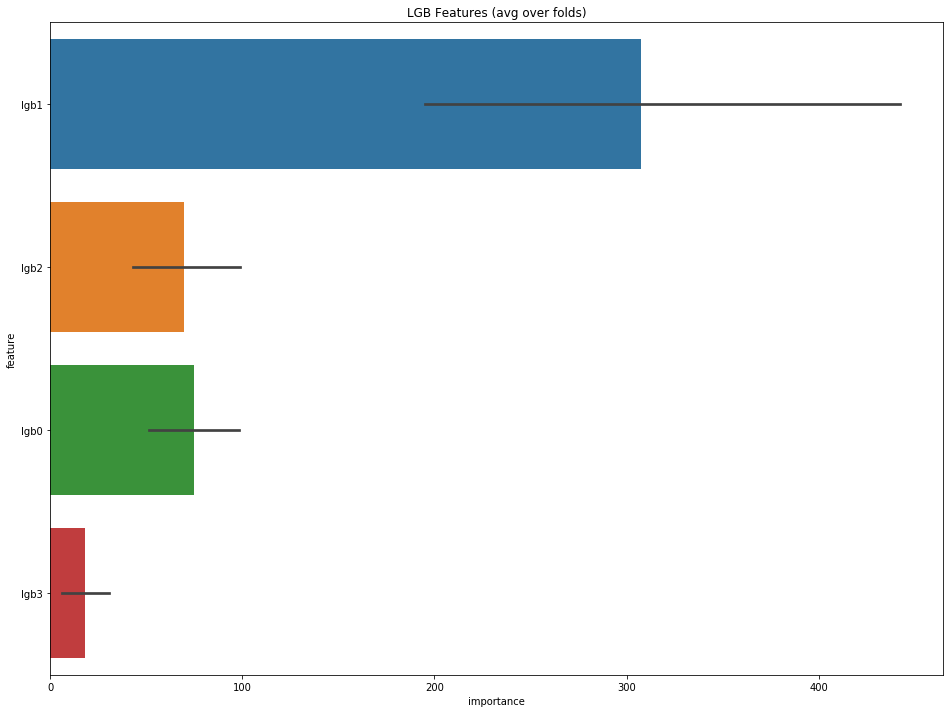

In [98]:
n_fold = 5
folds = KFold(n_splits=n_fold)

params = {
    'learning_rate': 0.001,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1 }

train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 500,
    'n_estimators': 5000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
}


result_dict_lgb = train_model_classification(X=oofs, X_test=predictions, y=y, params=params, folds=folds,
                                         model_type=train_options['model_type'], 
                                         eval_metric=train_options['eval_metric'],
                                         plot_feature_importance=True,
                                         verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                         n_estimators=train_options['n_estimators'], 
                                         averaging=train_options['averaging'],
                                         n_jobs=-1, groups=None)

In [99]:
result_dict_lgb

{'oof': array([[0.02078581],
        [0.0149805 ],
        [0.01078289],
        ...,
        [0.003937  ],
        [0.05838243],
        [0.00581695]]), 'prediction': array([[0.00983931],
        [0.00993099],
        [0.01044202],
        ...,
        [0.01445845],
        [0.01445845],
        [0.01095311]]), 'scores': [0.8979828678333852,
  0.9167376607738427,
  0.9008961443389444,
  0.9322624140242557,
  0.9128475062601893], 'feature_importance':   feature           importance  fold
 0    lgb0   69.400000000000006     1
 1    lgb1  253.599999999999994     1
 2    lgb2   61.600000000000001     1
 3    lgb3    9.400000000000000     1
 0    lgb0   56.600000000000001     2
 1    lgb1  267.600000000000023     2
 2    lgb2   58.399999999999999     2
 3    lgb3   12.000000000000000     2
 0    lgb0   36.799999999999997     3
 1    lgb1  111.799999999999997     3
 2    lgb2   24.199999999999999     3
 3    lgb3    1.000000000000000     3
 0    lgb0  100.400000000000006     4
 1    lgb1  3

In [ ]:
test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [102]:
folder_path = '../../data/'
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
sub['isFraud'] = result_dict_lgb['prediction']
sub.to_csv(f'submission_stack.csv', index=False)